In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from collections import Counter
from itertools import chain
from scipy.sparse import csc_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from gensim.models import LdaModel
from gensim.matutils import Sparse2Corpus
from utilsLDA import *

## Fitting LDA models

### Document-Term Matrices

In [3]:
# Unigram document-term matrix
data, row, col = [], [], []
for row_idx, doc in enumerate(id2doc):
    semTags = [ tag for ch in chain.from_iterable(documents[doc]) for tag in unigram_sem[ch] ]
    for tag, fq in Counter(semTags).items():
        col_idx = unigramSem2id[tag]
        data.append(fq)
        row.append(row_idx)
        col.append(col_idx)
csc_unigram = csc_matrix((data, (row, col)), shape=(len(id2doc), len(id2unigramSem)))

# Bigram document-term matrix
data, row, col = [], [], []
for row_idx, doc in enumerate(id2doc):
    semTags = [ tag for word in documents[doc] if len(word) == 2 for tag in bigram_sem[word] ]
    for tag, fq in Counter(semTags).items():
        col_idx = bigramSem2id[tag]
        data.append(fq)
        row.append(row_idx)
        col.append(col_idx)
csc_bigram = csc_matrix((data, (row, col)), shape=(len(id2doc), len(id2bigramSem)))

In [21]:
# n_categories = list(range(3, 22, 2))
n_categories = [12, 95, 1000]

In [22]:
LDA_unigram, LDA_bigram = [], []
corp_unigram = Sparse2Corpus(csc_unigram, documents_columns=False)
corp_bigram = Sparse2Corpus(csc_bigram, documents_columns=False)

for n_topics in tqdm(n_categories):
    m1 = LdaModel(corp_unigram, num_topics=n_topics, random_state=100)
    m2 = LdaModel(corp_bigram, num_topics=n_topics, random_state=100)
    LDA_unigram.append(m1)
    LDA_bigram.append(m2)

100%|█████████████████████████████████████████████| 3/3 [00:46<00:00, 15.66s/it]


In [23]:
dist_mat_unigram, dist_mat_bigram = [], []

for i in tqdm(list(range(len(n_categories)))):
    for j in [True, False]:
        if j == True:
            model = LDA_unigram[i]
        else:
            model = LDA_bigram[i]
        
        X = []
        for row_idx, doc1_id in enumerate(id2doc):
            p = get_document_topic_vec(doc1_id, model, unigram=j)
            X.append(p)
        X = np.array(X, dtype=float)
        dist_mat = pdist(X, "jensenshannon")
        dist_mat = squareform(dist_mat)
        for row_idx, col_idx in np.argwhere(np.isnan(dist_mat)):
            dist_mat[row_idx][col_idx] = 0.0
        
        if j == True:
            dist_mat_unigram.append(dist_mat)
        else:
            dist_mat_bigram.append(dist_mat)

100%|█████████████████████████████████████████████| 3/3 [02:38<00:00, 52.97s/it]


In [24]:
len(dist_mat_bigram)

3

In [25]:
from random import sample
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

adj_rand_score_unigram, adj_rand_score_bigram  = [], []
adj_rand_score_unigram_rnd, adj_rand_score_bigram_rnd  = [], []

for i, n_topic in enumerate(n_categories):
    true_labs = [ ''.join(C._parse_key(x)[:i+1]) for x in id2doc ]
    m1 = AgglomerativeClustering(n_clusters=n_topic, affinity='precomputed', linkage='average').fit(dist_mat_unigram[i])
    m2 = AgglomerativeClustering(n_clusters=n_topic, affinity='precomputed', linkage='average').fit(dist_mat_bigram[i])
    m1_labs, m2_labs = m1.labels_, m2.labels_
    s1, s2 = adjusted_rand_score(true_labs, m1_labs), adjusted_rand_score(true_labs, m2_labs)
    adj_rand_score_unigram.append(s1)
    adj_rand_score_bigram.append(s2)
    
    # Random baseline
    rnd_uni, rnd_bi = [], []
    for i in range(5):
        true_labs_rnd = sample(true_labs, len(true_labs))
        s1, s2 = adjusted_rand_score(true_labs_rnd, m1_labs), adjusted_rand_score(true_labs_rnd, m2_labs)
        rnd_uni.append(s1)
        rnd_bi.append(s2)
    adj_rand_score_unigram_rnd.append(rnd_uni)
    adj_rand_score_bigram_rnd.append(rnd_bi)

In [26]:
adj_rand_score_unigram

[0.05169581096417255, 0.037670617780384004, 0.0]

In [27]:
adj_rand_score_unigram_rnd

[[0.002545966852257537,
  0.00040085636183025835,
  -0.0013688597927722463,
  0.0016968606164634056,
  0.0001059036693965076],
 [-0.0008876982632501795,
  0.0006406040620660552,
  0.00266998911699417,
  -1.080348642938905e-05,
  -0.0015140516752650299],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

In [28]:
adj_rand_score_bigram

[0.0365168999627871, 0.03521974032259324, 0.0]

In [29]:
adj_rand_score_bigram_rnd

[[0.0022006415201360407,
  -0.0007306166819837722,
  -0.00044122494865347217,
  0.0009777280663854182,
  -0.0003665432110198464],
 [0.00037895522743597266,
  0.0013636880497755455,
  0.0010354437756623545,
  0.0021608527154790094,
  0.00037895522743597266],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

In [20]:
adjusted_rand_score([2, 1, 1, 3], ['b', 'b', 'a', 'a'])

-0.2857142857142857

## Clustering Hyperparameter exploration

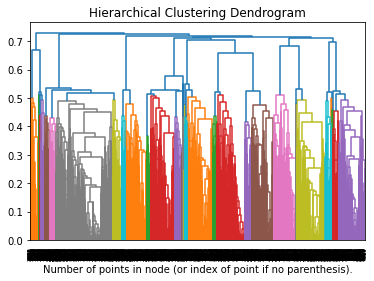

In [13]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed', linkage='average')
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(dist_mat)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model) #, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()